<a href="https://colab.research.google.com/github/r-siddiqi/PHY-329_Project/blob/main/Integrated_Square_Lattice_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
import itertools

The following class provides supports for simulating Anderson localization and the Hofstader model on a finite square lattice with periodic boundary conditions. The possible outputs are a plot of the eigenvalue spectrum, an eigenvector from the middle of the spectrum, the participation ratio, and the Hofstader butterfly.

A feature of this code is the lack of dependence on crystal momentum.

The $\phi$ parameter allows you to impose a magnetic field onto the hamiltonian and see its impact on the eigenvalues, eigenvectors, and inverse participation ratio.

Note that the butterfly construction depends on the $q$ parameter and NOT phi. This is because there are certain allowed coprime integer pairs $(p,q)$ that can define $\phi$, and we can set a maximum value for $q$. Then, the butterfly will be generated over all possible allowed $p/q$ ratios up to the maximum allowed $q$ set by the user.

An interesting result to note is that the presence of disorder (it doesn't matter what the physical cause of it may be) kills the butterfly fractal. This idea is discussed in https://journals.aps.org/prb/abstract/10.1103/PhysRevB.71.125310 and https://link.springer.com/chapter/10.1007/978-3-030-21511-8_5 .


In [2]:
class Square_Hamiltonian:
    """ Square lattice simulation with Anderson localization and a magnetic field"""

    def __init__(self, length: int, t: float, W: float, phi: float, q: int):
        """
          Initialize Square_Hamiltonian class.

          Parameters:
              length (int): Lattice size (L x L).
              t (float): Hopping parameter.
              W (float): Disorder parameter.
              phi (float): Magnetic flux per plaquette (in units of flux quantum).
              q (int): Maximum denominator for phi values in Hofstadter butterfly.
          """

        self.L = length  # Lattice dimension
        self.N = self.L * self.L  # Total number of sites
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per plaquette
        self.max_q = q  # Maximum denominator for phi values
        self.matrix = np.zeros((self.N, self.N), dtype=complex)  # Hamiltonian matrix

        # Initialize on-site disorder potentials
        self.on_site_potential = np.zeros(self.N)

        # Initialize boundary fluxes - these do not contribute to the flux plaquett
        self.phi_x = 0.0  # Flux through x direction
        self.phi_y = 0.0  # Flux through y direction

    """ Defining and diagonalizing the Hamiltonian for the system """

    def disorder_setter(self):
        # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        self.on_site_potential = self.disorder * (2 * np.random.rand(self.N) - 1)

    def peierls_phase(self, i, j, direction):
        """
        Calculate the Peierls phase for hopping between sites.

        Parameters:
            i (int): x-index of the starting site.
            j (int): y-index of the starting site.
            direction (str): 'x' for horizontal hopping, 'y' for vertical hopping.

        Returns:
            float: Phase factor for hopping term.
        """
        # Using Landau gauge
        if direction == 'x':
            # Hopping in the x-direction
            phase = 0.0
            if (i + 1) >= self.L:
                # Boundary hopping in x-direction
                phase += 2 * np.pi * self.phi_x
            return np.exp(1j * phase)
        elif direction == 'y':
            # Hopping in the y-direction
            phase = 2 * np.pi * self.phi * i
            if (j + 1) >= self.L:
                # Boundary hopping in y-direction
                phase += 2 * np.pi * self.phi_y
            return np.exp(1j * phase)


    def construct_hamiltonian(self):
        # Construct the Hamiltonian matrix with hopping, Peierls phases, and disorder.
        self.disorder_setter()
        self.matrix = np.zeros((self.N, self.N), dtype=complex)

        for i, j in np.ndindex((self.L, self.L)):
            n = i * self.L + j  # Current site index

            # On-site potential
            self.matrix[n, n] = self.on_site_potential[n]

            # Hopping in x-direction (to site (i+1, j))
            m_x = ((i + 1) % self.L) * self.L + j
            phase_x = self.peierls_phase(i, j, 'x')
            self.matrix[n, m_x] = -self.t * phase_x

            # Hopping in y-direction (to site (i, j+1))
            m_y = i * self.L + (j + 1) % self.L
            phase_y = self.peierls_phase(i, j, 'y')
            self.matrix[n, m_y] = -self.t * phase_y

        # Ensure the Hamiltonian is Hermitian
        self.H = self.matrix + self.matrix.conj().T

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(self.H)

    """ Basic plotting functions """

    def plot_evals(self):
        # Plot eigenvalues of hamiltonian matrix
        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.plot(self.evals, '.')
        plt.ylabel(r'Eigenvalues $E_i$')
        plt.xlabel('Index $i$')
        plt.title('Eigenvalues of the Hamiltonian')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec(self):
        # Plot some eigenvector in the middle of the spectrum
        self.psi = self.evecs[:,self.L//2]

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_evec_disorder(self):
        # Plot some eigenvector in the middle of the spectrum in the presence of disorder
        self.psi = self.evecs[:,self.L//2] # Some eigenvector in the middle of the spectrum

        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.title('Arbitrary Eigenvector')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    def plot_pr(self):
        # Plot Participation Ratio
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0) # 'evecs' is a matrix of $\psi_i(x)$ amplitudes, 1st axis is x. This does the sum over x.

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('Energy $E$')
        plt.ylabel('Inverse Participation Ratio (IPR)')
        plt.title('Localization Properties')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

    """ Advanced computations and plotting """

    def plot_hofstadter_butterfly(self):
        # Plot the Hofstadter butterfly
        plt.figure(figsize=(10, 8))
        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                if gcd(p, q) == 1:
                    self.phi = p / q
                    self.construct_hamiltonian() # Reconstruct hamiltonian for each allowed phi
                    phis.extend([self.phi] * self.N)
                    energies.extend(self.evals.tolist())

        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel('Flux per Plaquette $\phi$')
        plt.ylabel('Energy $E$')
        plt.title('Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$')
        plt.grid(True)
        plt.show()

    def plot_density_of_states(self, sigma=0.1, num_points=1000):
        """
        Plot the density of states.

        Parameters:
            sigma (float): Standard deviation for Gaussian broadening.
            num_points (int): Number of points in the energy grid.
        """
        energy_min = np.min(self.evals) - 1
        energy_max = np.max(self.evals) + 1
        E_vals = np.linspace(energy_min, energy_max, num_points) # Artificial energy space seperate to eigenvalues
        dos = np.zeros_like(E_vals)

        for E_n in self.evals:
            dos += np.exp(-((E_vals - E_n) ** 2) / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma) # Using gaussian broadening

        legend = f'L={self.L}, t={self.t}, W={self.disorder}, $\phi$={self.phi}'
        plt.figure(figsize=(8, 6))
        plt.plot(E_vals, dos)
        plt.xlabel('Energy $E$')
        plt.ylabel('Density of States $g(E)$')
        plt.title('Density of States vs Energy')
        plt.legend([legend])
        plt.grid(True)
        plt.show()

## Examples

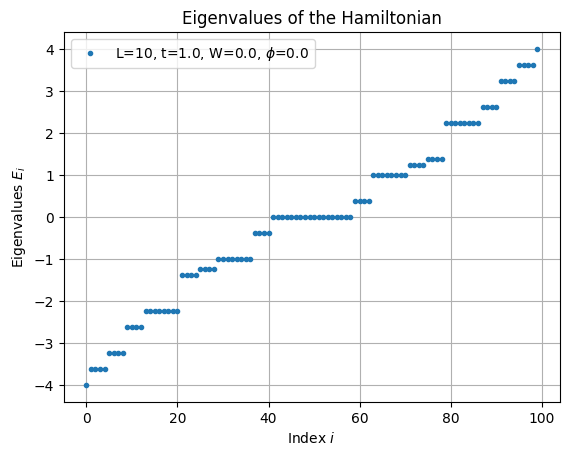

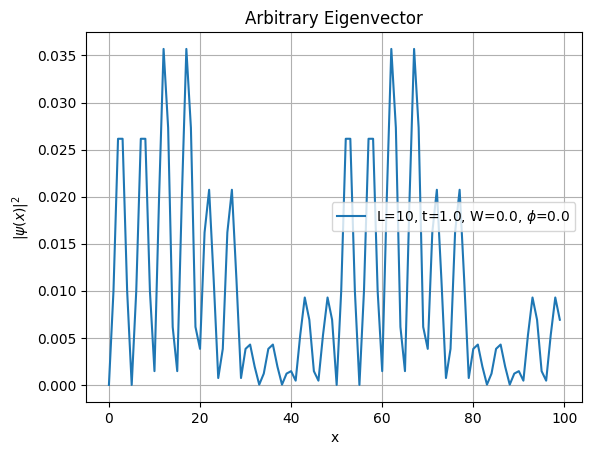

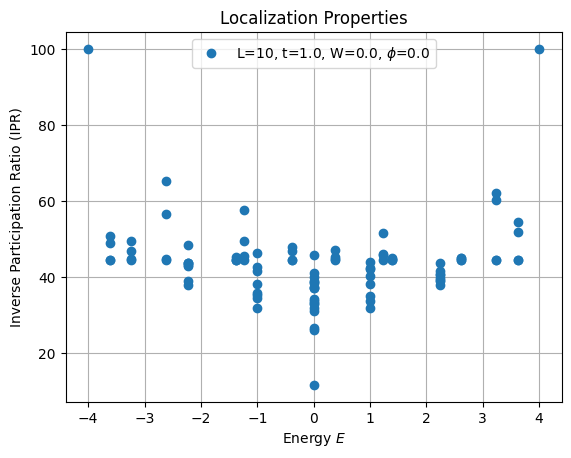

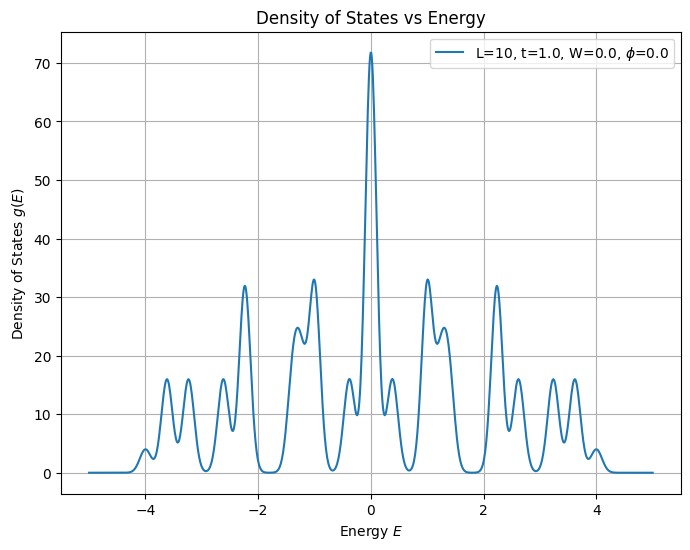

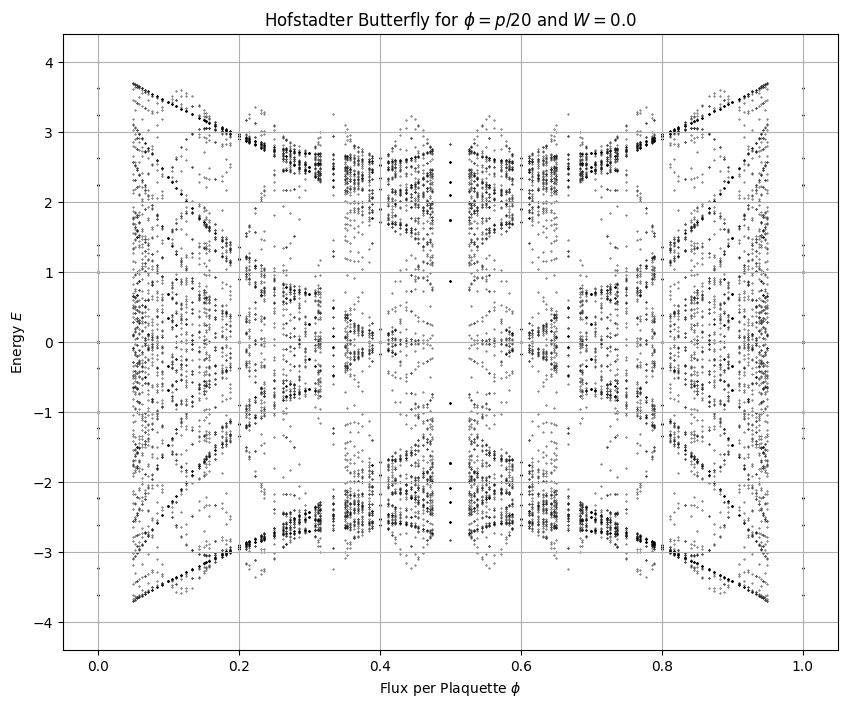

In [4]:
model = Square_Hamiltonian(length=10, t=1.0, W=0.0, phi=0.0, q=20)
model.construct_hamiltonian()
model.plot_evals()
model.plot_evec()
model.plot_pr()
model.plot_density_of_states()
model.plot_hofstadter_butterfly()